# A first look at data

date: 12/04/2018

Example code for reading and checking data


In [1]:
import pandas as pd
import dask.dataframe as dd
import glob as glob
import numpy as np
from scipy.stats import kde

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import LogNorm
plt.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

In [ ]:
filename = '/data/IceCube/2015/output_126836_IC86.2015.hdf'
dataGen = pd.read_hdf(filename, key='Laputop', columns=['x'])
dataGen.drop(dataGen.columns.difference(['x']), 1, inplace=True)
print(dataGen)

In [ ]:
def merge_and_select_data(filenames, output, number_of_files=10000):
    store =pd.HDFStore(output,complib='blosc')
    for i, file in enumerate(filenames):
        print(i, file)
        s = pd.HDFStore(file)
        dataGen = s.select('Laputop')
        dataGen.drop(dataGen.columns.difference(['Run', 'Event','x','y','z','zenith','azimuth','time']), 1, inplace=True)
        dataRec = s.select('LaputopParams')
        dataRec.drop(dataRec.columns.difference(['s125','beta','chi2','ndf']), 1, inplace=True)
        dataCuts = s.select('IT73AnalysisIceTopQualityCuts')
        dataCuts.drop(['Run', 'Event','SubEvent','SubEventStream'], 1, inplace=True)
        dataGen = dataGen.dropna(axis=1, how='all')
        dataRec = dataRec.dropna(axis=1, how='all')
        data = pd.concat([dataGen, dataRec, dataCuts], axis=1, join_axes=[dataGen.index])
        data = data.query('exists!=0 & IceTopMaxSignalInside!=0 & IceTop_reco_succeeded!=0'
                         ' & IceTop_StandardFilter!=0 & IceTopMaxSignalInside !=0 '
                         ' & Laputop_FractionContainment!=0 & BetaCutPassed!=0 &s125>1')
        data.drop(data.columns.difference(['Run','Event','x','y','z','zenith','azimuth',
                                          's125','beta','chi2','ndf']), axis=1,inplace=True)
    
        store.append(key ='data', value=data,  format='t',chunksize=200000)
        s.close()
        if i>number_of_files:
            break

    return store

In [ ]:
filenames = glob.glob('/data/IceCube/2015/*')

number_of_files = 10000
store = merge_and_select_data(filenames, '/data/IceCube/merged2015.h5', number_of_files )        
dataAll = pd.DataFrame() 
dataAll = store.select('data')
print(dataAll.count())
store.close()    




In [2]:
df = pd.DataFrame()
df = pd.read_hdf('/data/IceCube/merged2015.h5', key='data')
df['cos2'] = np.cos(df.zenith)**2
df['I'] = 0
df.drop(df.columns.difference(['s125',"cos2"]), 1, inplace= True)

#df.drop(["Run", "Event"], 1, inplace = True)


s125    55326
cos2    55326
dtype: int64


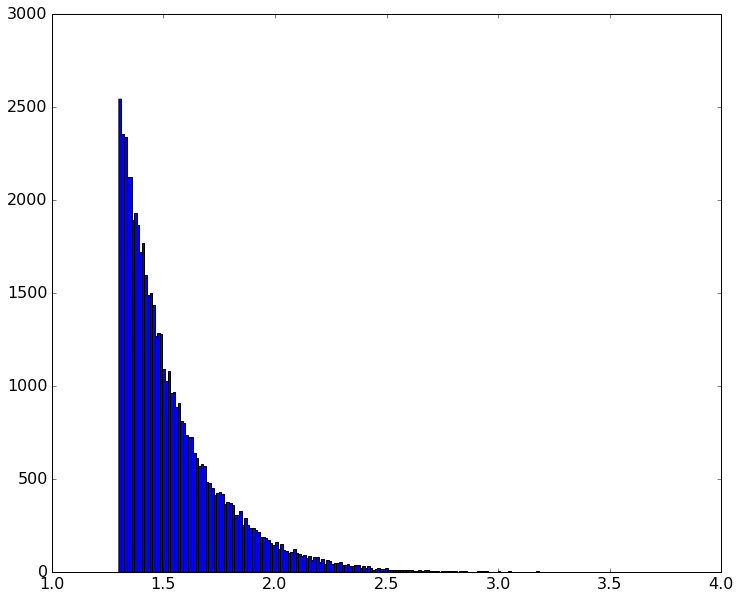

In [3]:
#hist = plt.hist(np.degrees(df.zenith), bins=150)
df= df.loc[df.s125>20]
df= df.loc[df.cos2>0.5]  
print(df.count())
hist= plt.hist(np.log10(df.s125),bins= 200)

In [4]:
from simul_functions import set_intensity
bins = 10
df['I'] = 0
df.reset_index(inplace=True)

df[df.index.duplicated()]
#print(df)
df = set_intensity(df, 10)


        index        s125      cos2    I
46024    3501  125.141560  0.521332  100
8562    64271  149.341642  0.601082  100
47858  153770  174.827338  0.634646  100
50890   17154  178.161097  0.692480  100
10715   48746  183.884127  0.725183  100
33324  159789  189.632938  0.985256  100
30077  133044  192.270278  0.838203  100
48006   22441  194.240707  0.904971  100
53789   74761  197.217391  0.812293  100


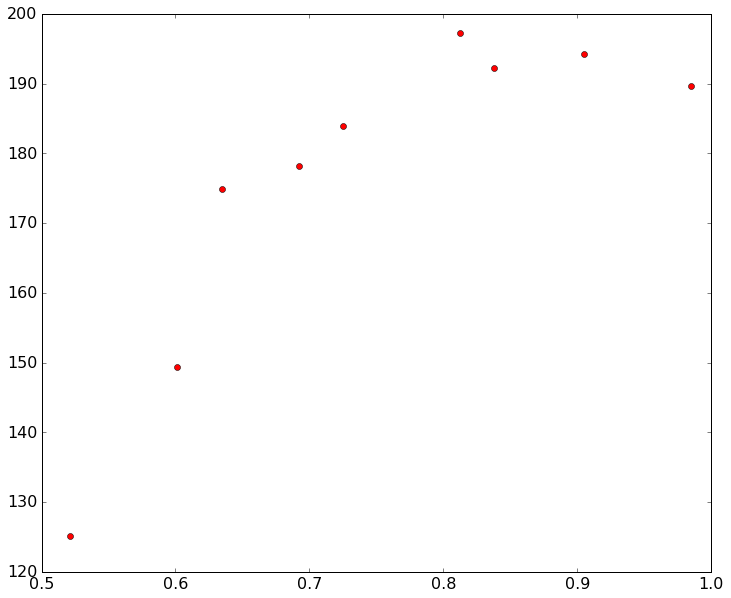

In [14]:
np.cos(np.radians(45))**2

#plt.plot(np.log10(df.s125),np.log10(df.I), 'ro')

values = df.loc[df.I==100]
print(values)
plt.plot(values.cos2, values.s125, 'ro')